# Catalog (self-note)
# 1. Hurst Exponent function / Correlogram Plot definition
# 2. Data prep & settings
# 3. Observe volatility clustering by ACF, PACF, Q-Q plot, ADF p-value of series
# 4. Calculate volatility
# 5. GARCH/ARCH simulation with parameters changing
    Assuming n,omega,alpha,beta,etc. and change beta
# 6. Basic Garch model implement & forecast --> fit with skewed t-distribution
    because financial time series data always far away from mean
# 7. Use ARIMA model residual to fit Garch model
    a. Searching over model orders to find the optimal number of lags
# 8. Fit Garch into Bitcoin 
    a. Load b. correlogram c.daily volatility d.Compare GJR-GARCH with EGARCH
# 9. Rolling window forecasting / fixed window forecasting and compare them
# 10. simplify the model with p-value, t stat, Ljung-Box test
# 11. model estimation by Goodness of fit & backtesting (MAE, MSE)
    (bitcoin)goodness of fit: Maximum likelihood;Information criteria (AIC, BIC)
# 11. Simulating Forecasts / Bootstrap Forecasts
# 12. parametric VaR and empirical VaR
    (bitcoin)Step 1 is to use a GARCH model to make variance forecasts. Step 2 is to obtain the GARCH forward-looking mean and volatility. And Step 3 is to compute the quantile according to a given confidence level
# 13. Covariance (can be used to find the movement of 2 assets)

In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [1]:
# datetime.fromtimestamp(timestamp)

In [59]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 30,30

In [32]:
bitcoin_data = pd.read_csv('btc2020-01-01_2021-06-30.csv', index_col='Date')
# bitcoin_data.index = pd.to_datetime(bitcoin_data.index, format='%Y-%m-%d')
bitcoin_data = bitcoin_data.loc[(bitcoin_data != 0.0).any(axis=1)]
bitcoin_data['Return'] = np.log(bitcoin_data['close']).diff().mul(100) # rescale to faciliate optimization
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13103 entries, 1/1/20 1:00 to 6/29/21 23:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   close      13103 non-null  float64
 1   high       13103 non-null  float64
 2   low        13103 non-null  float64
 3   open       13103 non-null  float64
 4   timestamp  13103 non-null  int64  
 5   volume     13103 non-null  float64
 6   Return     13103 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 818.9+ KB


In [ ]:
# Plot bitcoin price data 
fig, ax1 = plt.subplots(figsize=(40, 40))
ax1.set_yscale('log')
ax1.plot(bitcoin_data.index, bitcoin_data.close, color='b', label='BTCUSD')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTCUSD Close')
ax1.legend()
plt.xticks(rotation = 90)
# plt.show()
for i, t in enumerate(ax1.get_xticklabels()):
    if (i % 500) != 0:
        t.set_visible(False)

In [11]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [12]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

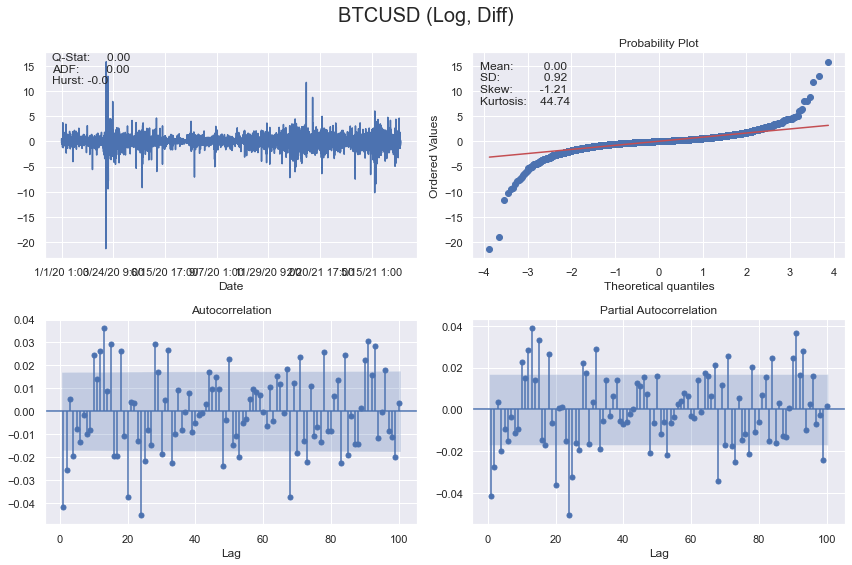

In [34]:
plot_correlogram(bitcoin_data['Return'], lags=100, title='BTCUSD (Log, Diff)')

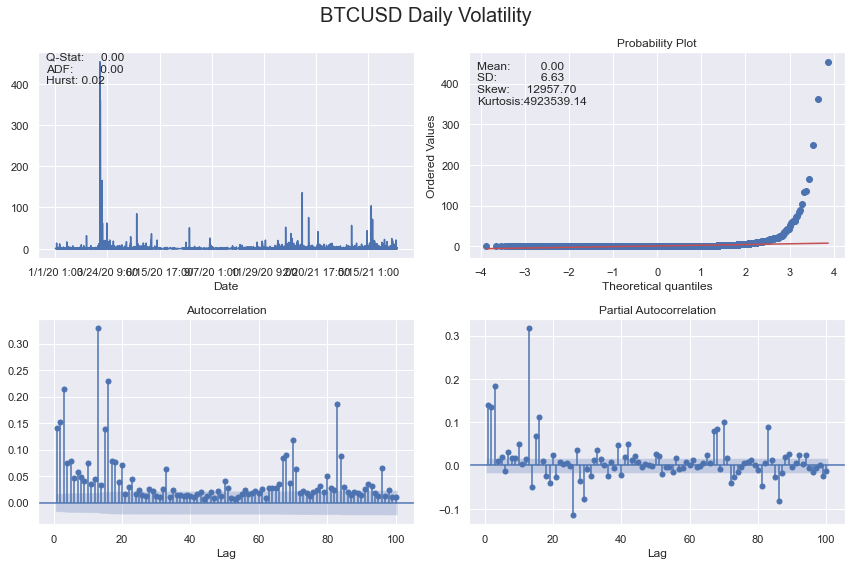

In [35]:
plot_correlogram(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), lags=100, title='BTCUSD Daily Volatility')

In [118]:
# # Specify GJR-GARCH model assumptions
# gjr_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# # Fit the model
# gjrgm_result = gjr_gm.fit(disp = 'off')

# # Print model fitting summary
# print(gjrgm_result.summary())

In [44]:
# # Specify EGARCH model assumptions
# egarch_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# # Fit the model
# egarch_result = egarch_gm.fit(disp = 'off')

# # Print model fitting summary
# print(egarch_result.summary())

# compare the estimated conditional volatility from the two models by plotting their results. (GJR-GARCH | EGARCH)

In [45]:
# gjrgm_vol = gjrgm_result.conditional_volatility
# egarch_vol = egarch_result.conditional_volatility

# # Plot the actual Bitcoin returns
# plt.plot(bitcoin_data['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# # Plot GJR-GARCH estimated volatility
# plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# # Plot EGARCH  estimated volatility
# plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

# plt.legend(loc = 'upper right')
# plt.show()

In [ ]:
# # Print each models BIC
# print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
# print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH is more conservative in volatility estimation when applying it to the Bitcoin dataset, but EGARCH yields the better model.

# Fixed rolling window forecast

In [3]:
#observe
eth_data=pd.read_csv('eth2020-01-01_2021-06-30.csv', index_col='Date')
eth_data['Return'] = 100 * (eth_data['close'].pct_change())
eth_data['Log_Return'] = np.log(eth_data['close']).diff().mul(100) # rescale to faciliate optimization
eth_data = eth_data.dropna()

model the log-returns of the props data with an ARMA model and then fit the models residuals to estimate the volatility of the returns series with a GARCH model.

In [4]:
import pmdarima as pm

model = pm.auto_arima(eth_data['Log_Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=41009.935, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=41015.237, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=41015.981, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=41015.326, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=41016.456, Time=1.47 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=41016.330, Time=1.56 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=41008.393, Time=0.41 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=41017.781, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=41025.182, Time=1.50 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=41012.688, Time=0.81 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 7.608 seconds


In [5]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                13103
Model:               SARIMAX(0, 0, 2)   Log Likelihood              -20489.976
Date:                Fri, 30 Jul 2021   AIC                          40985.952
Time:                        14:07:55   BIC                          41008.393
Sample:                             0   HQIC                         40993.447
                              - 13103                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0270      0.003     -8.220      0.000      -0.033      -0.021
ma.L2         -0.0362      0.004    -10.099      0.000      -0.043      -0.029
sigma2         1.3359      0.004    371.040      0.0

In [6]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=eth_data['Log_Return'],order=(0, 0, 1))
_model_result = _arma_model.fit()

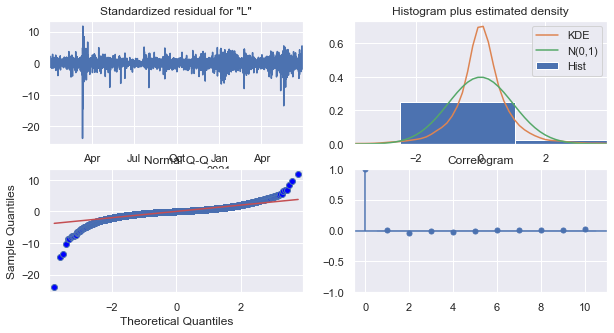

In [7]:
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [8]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -17757.2
Distribution:                  Normal   AIC:                           35520.5
Method:            Maximum Likelihood   BIC:                           35542.9
                                        No. Observations:                13103
Date:                Fri, Jul 30 2021   Df Residuals:                    13103
Time:                        14:08:14   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0158  6.971e-03      2.265  2.351e-02 [2.

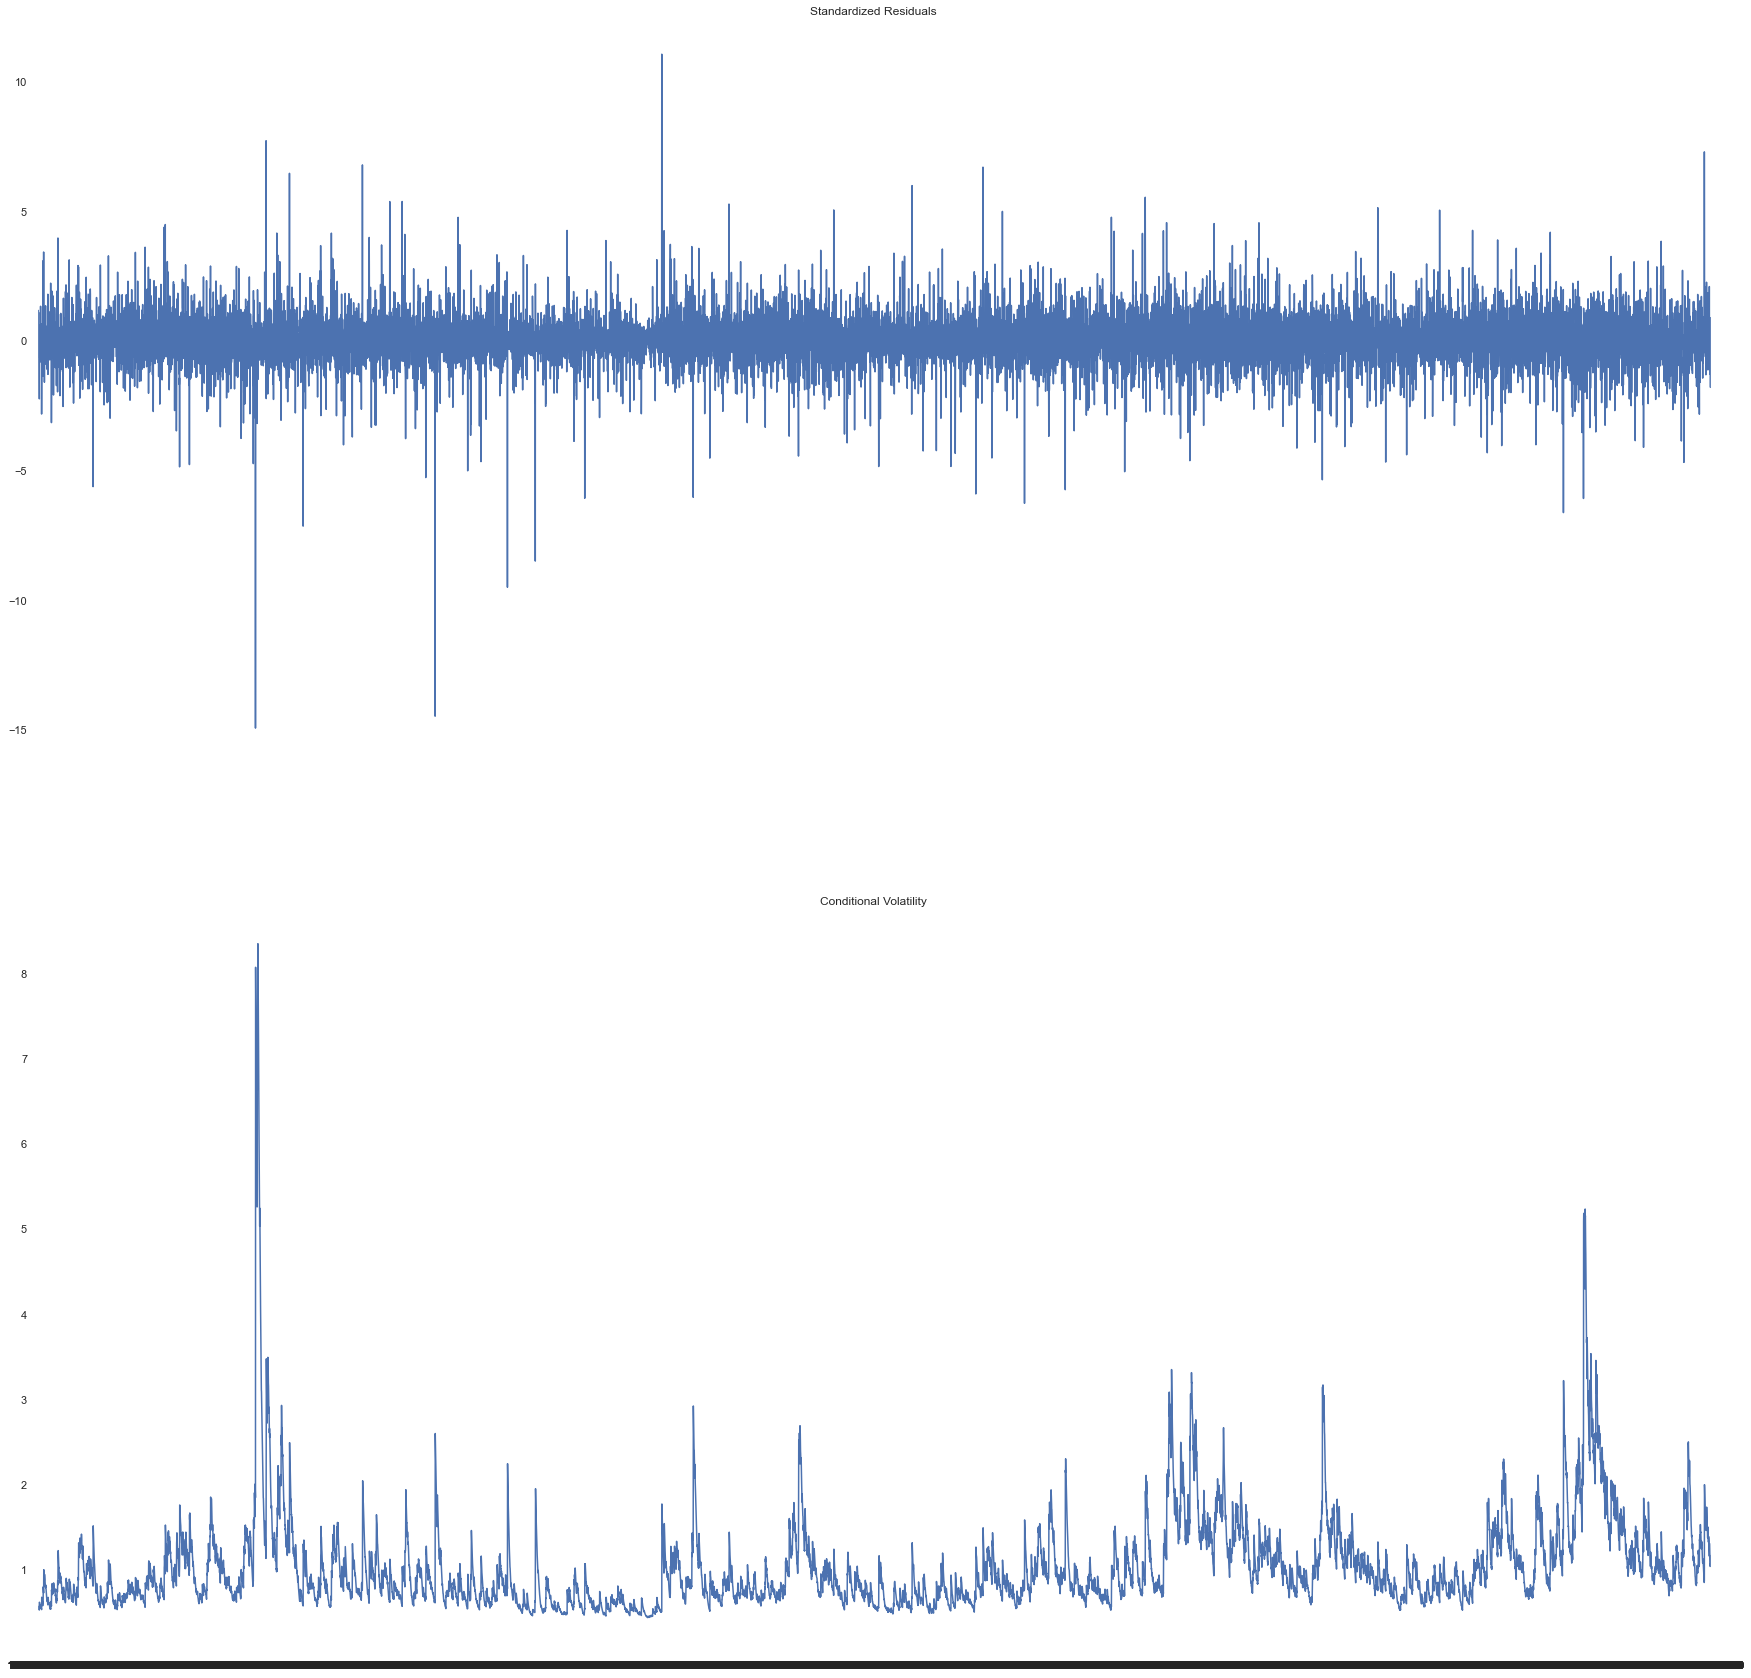

In [112]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.show()

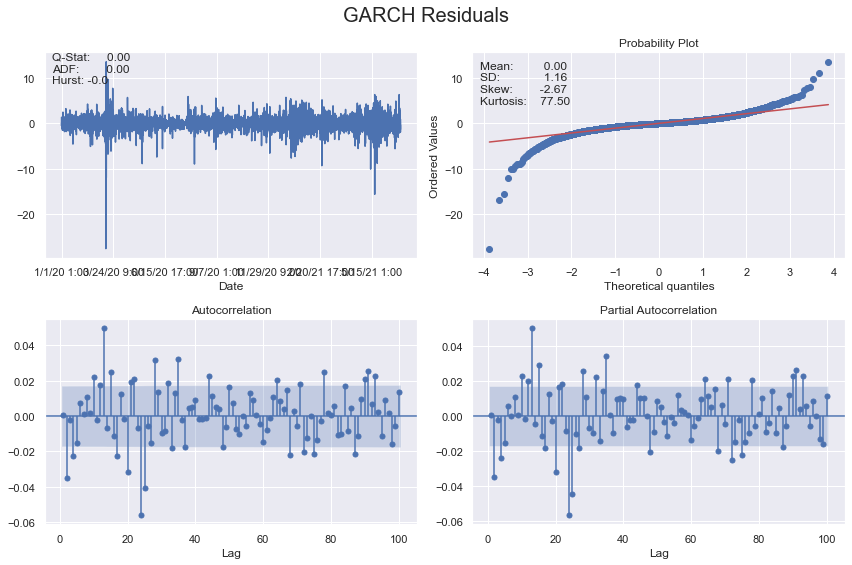

In [13]:
plot_correlogram(_garch_result.resid.dropna(), lags=100, title='GARCH Residuals')

# Fixed rolling window forecast and implementation

In [14]:
index = eth_data.index
start_loc = 0
end_loc = np.where(index >= '2021-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


In [15]:
index = eth_data.index
start_loc = 0
end_loc = np.where(index >= '2021-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


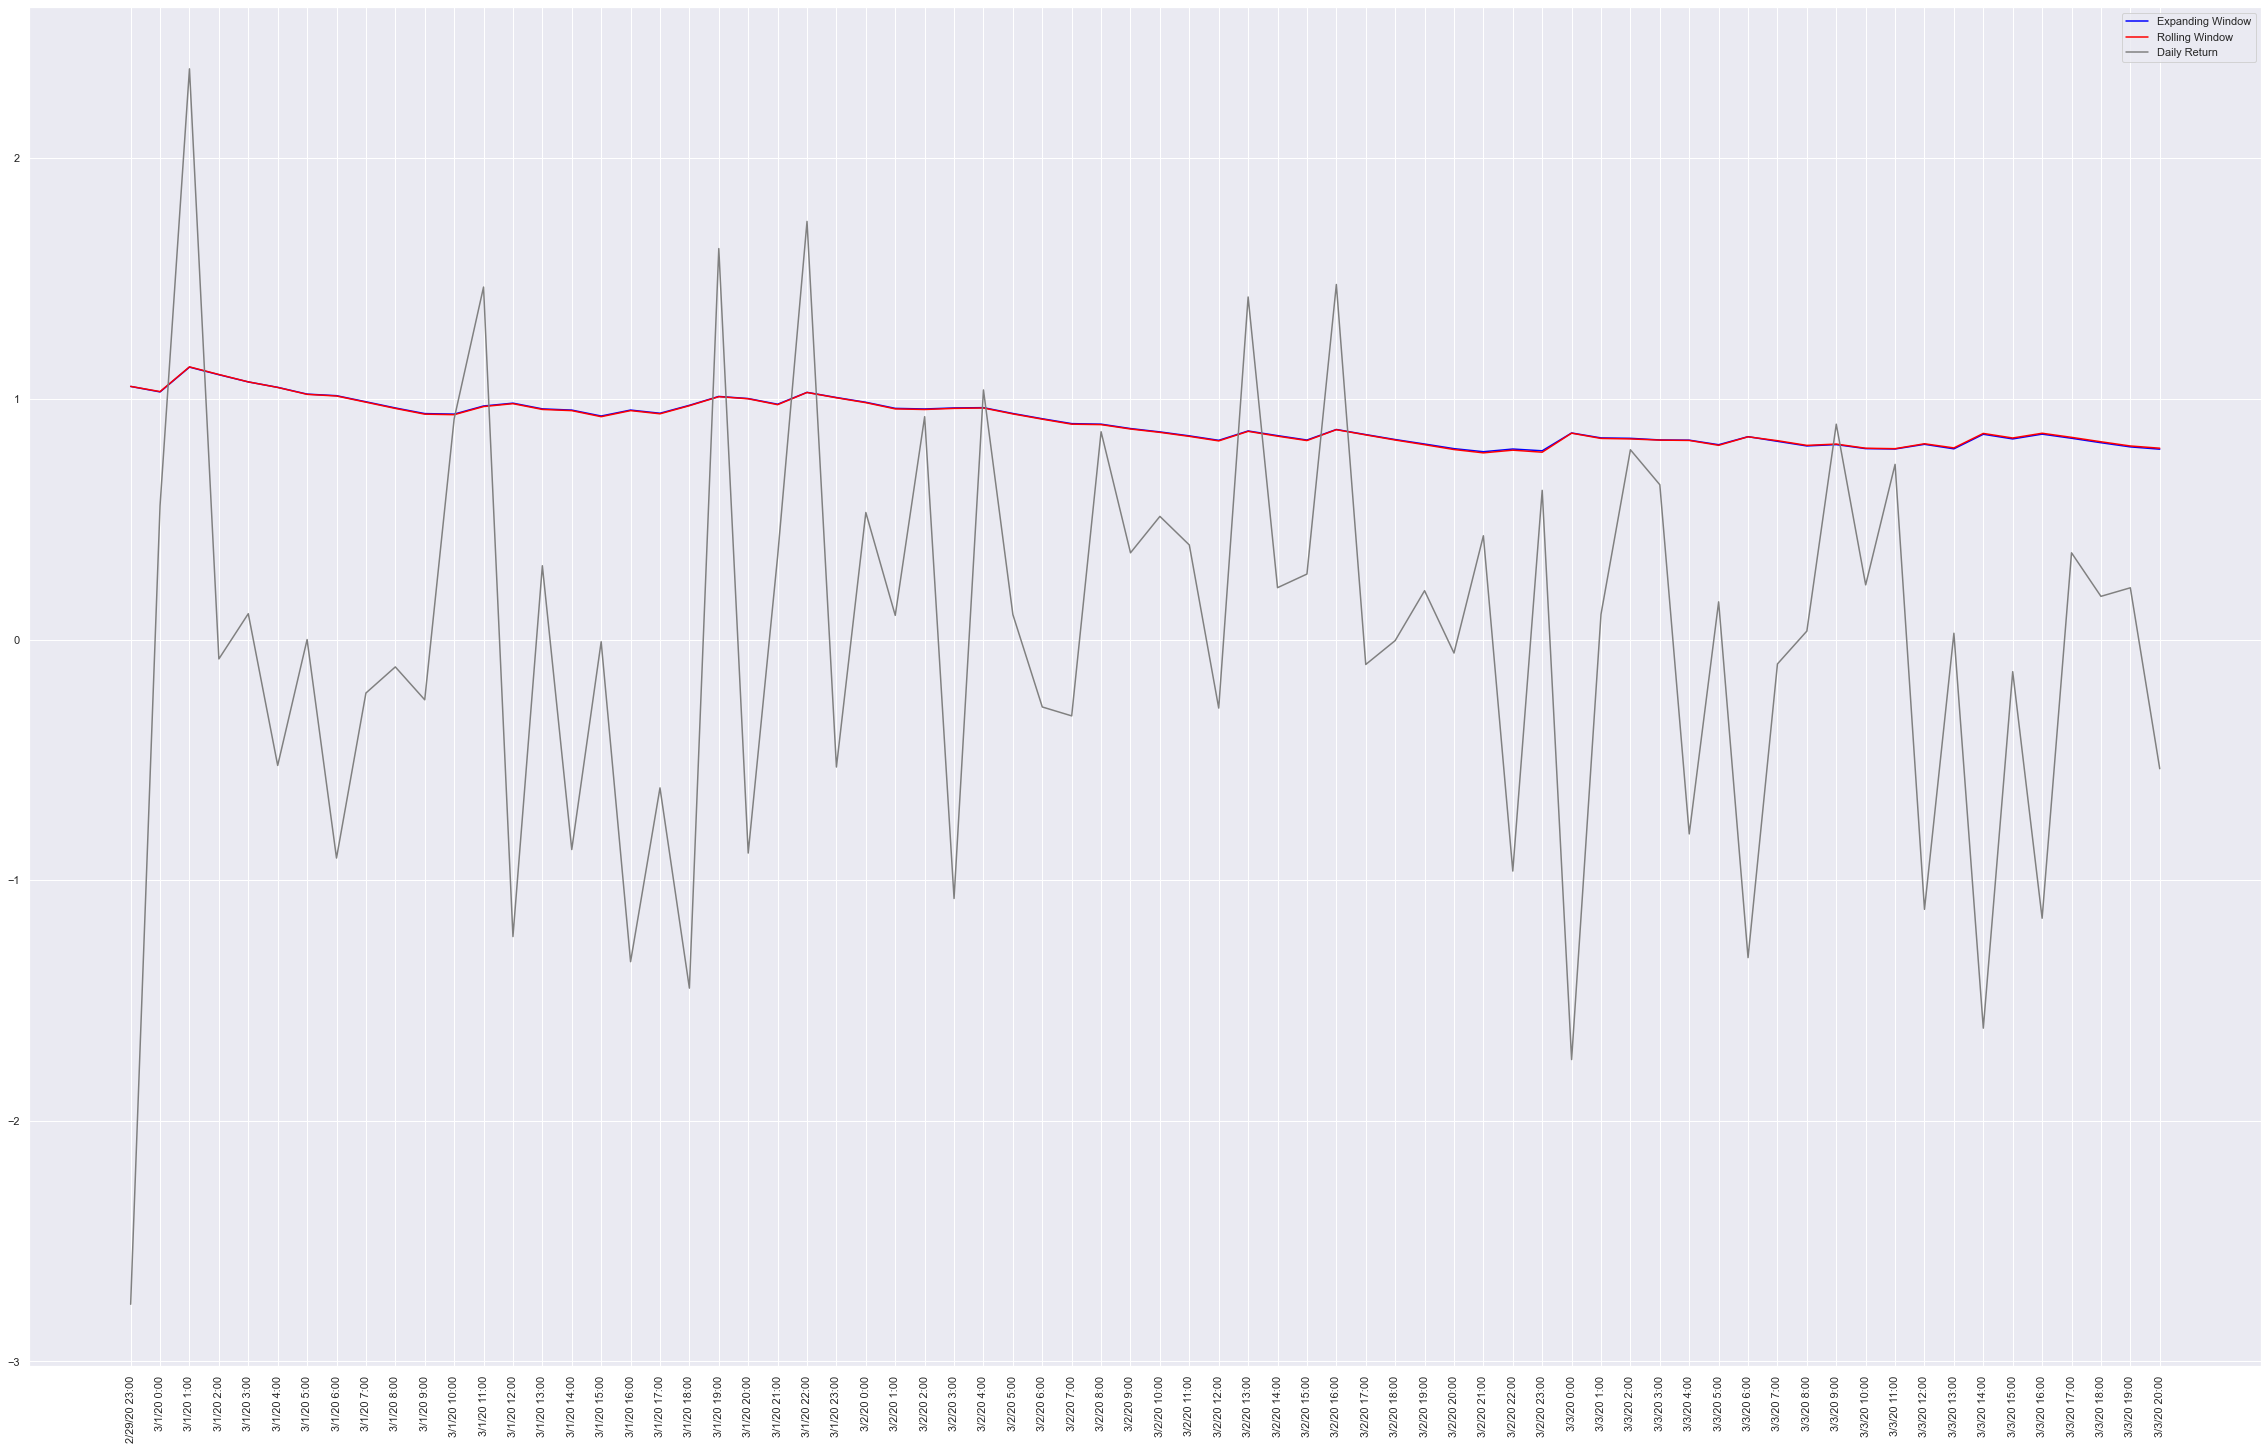

In [73]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(40,25))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')
plt.xticks(rotation = 90)

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(eth_data.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

In [17]:
print(np.where(index >= '2021-1-1'))

(array([ 1439,  1440,  1441, ..., 13100, 13101, 13102]),)


# General basic garch model

In [18]:
# Specify GARCH model assumptions
basic_gm = arch_model(eth_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     28,   Neg. LLF: 18411.2370628667
Iteration:      8,   Func. Count:     52,   Neg. LLF: 22624.589772093503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17711.18564765842
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


In [19]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -17711.2
Distribution:                  Normal   AIC:                           35430.4
Method:            Maximum Likelihood   BIC:                           35460.3
                                        No. Observations:                13103
Date:                Fri, Jul 30 2021   Df Residuals:                    13102
Time:                        14:18:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0317  7.477e-03      4.242  2.215e-05 [1.

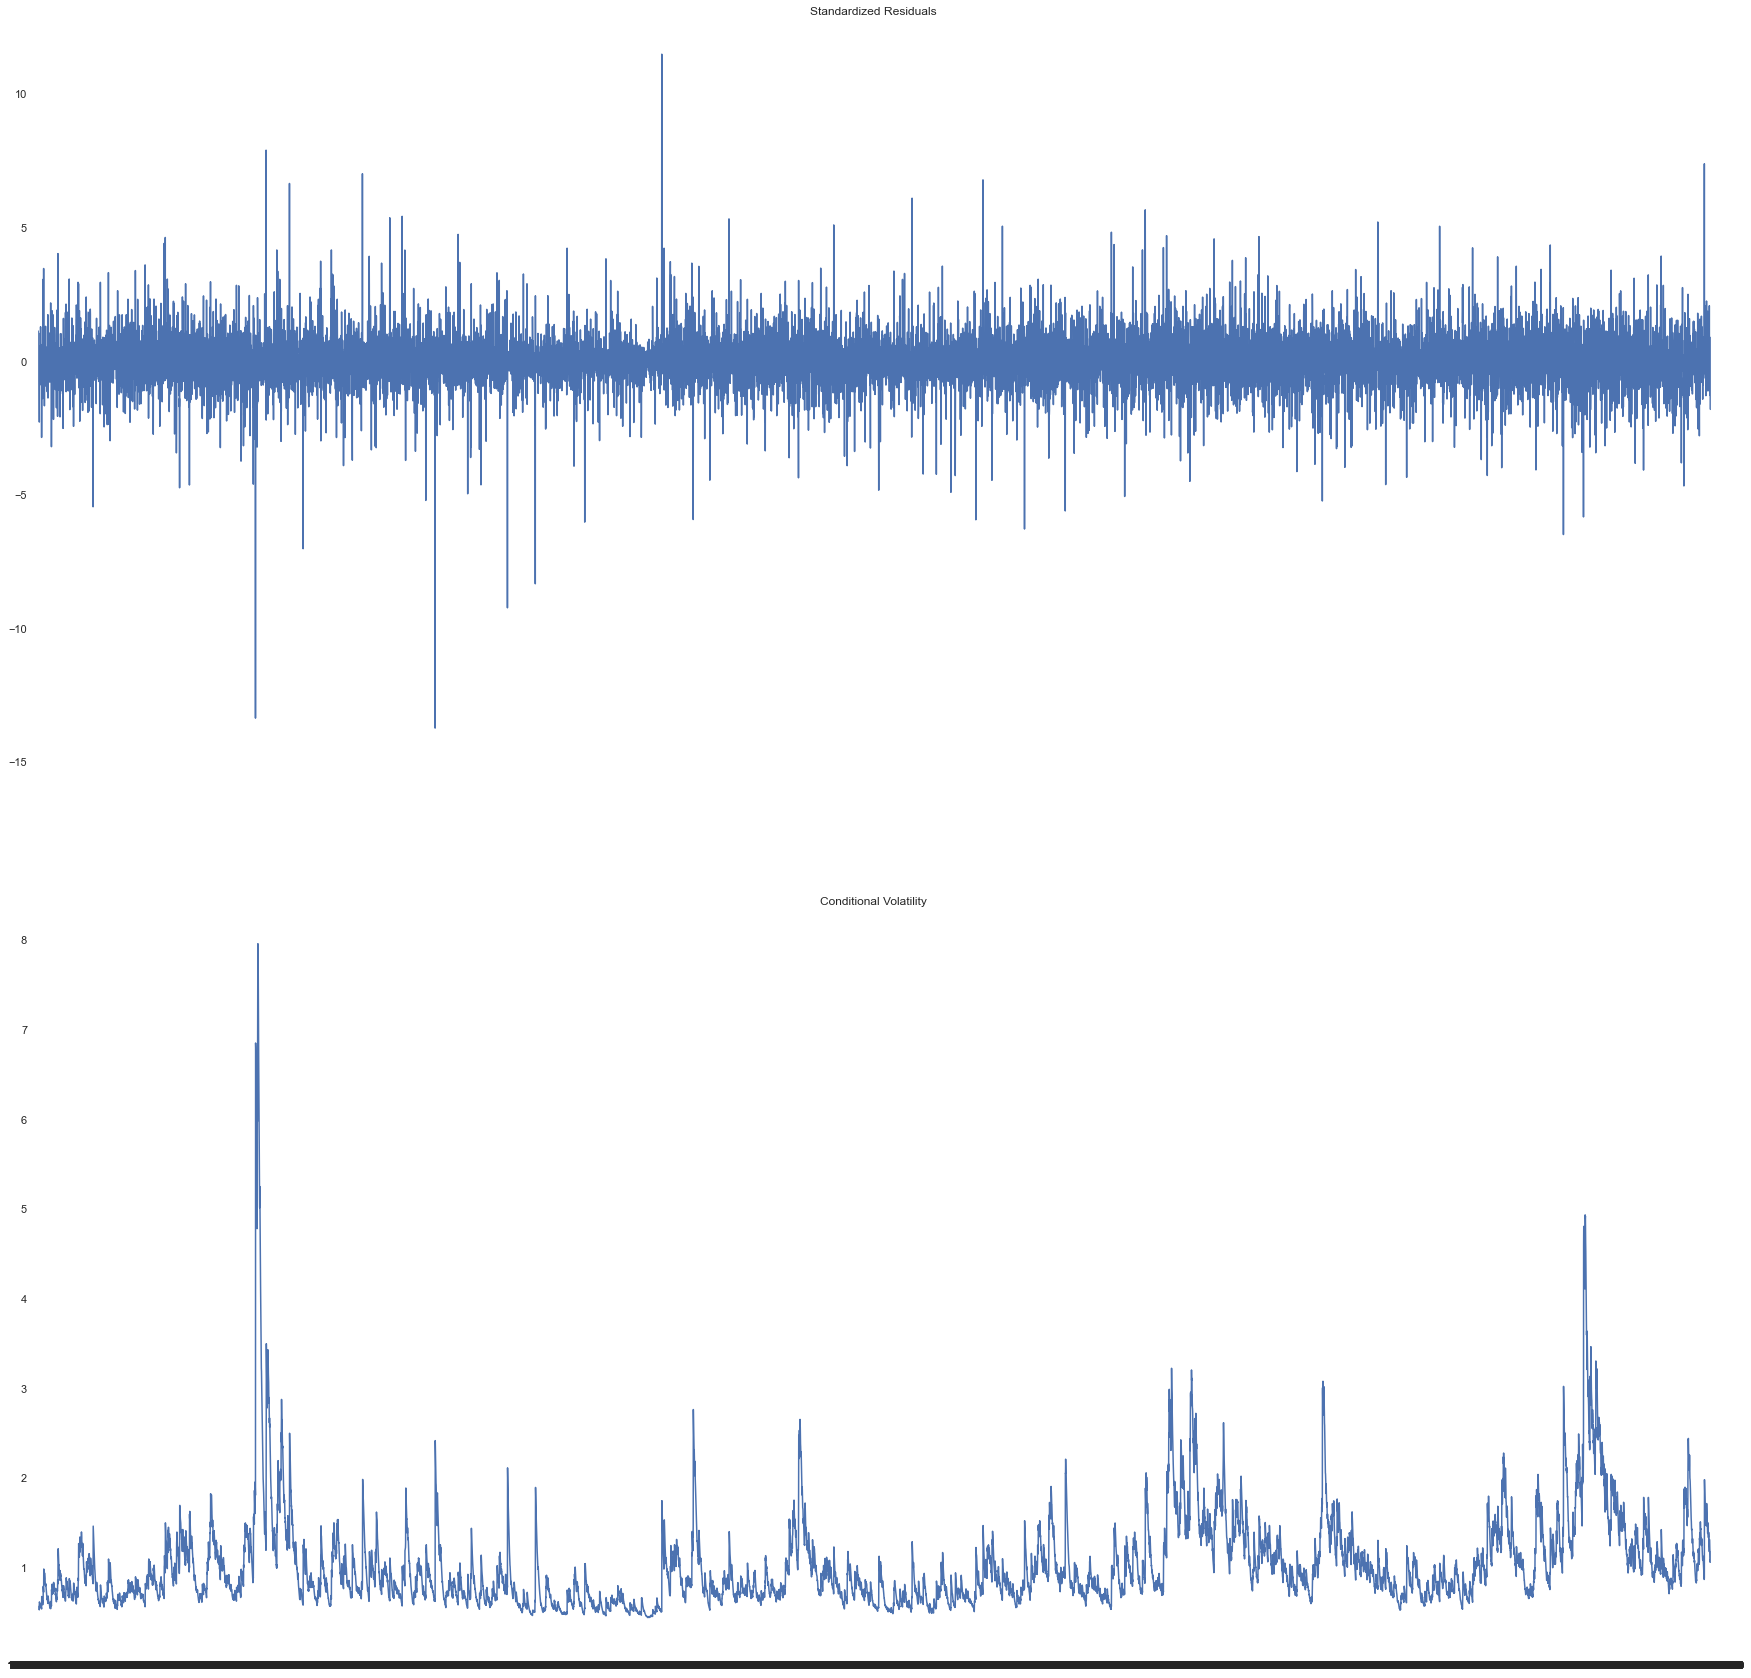

In [113]:
# Plot fitted results
gm_result.plot()
plt.show()

In [21]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                   h.1       h.2       h.3       h.4       h.5
Date                                                          
6/29/21 23:00  1.26986  1.273488  1.277086  1.280652  1.284187


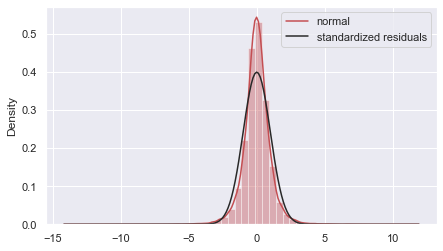

In [22]:
# student t distribution because of away from mean reality
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(20,20))
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [23]:

# Specify GARCH model assumptions
skewt_gm = arch_model(eth_data['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

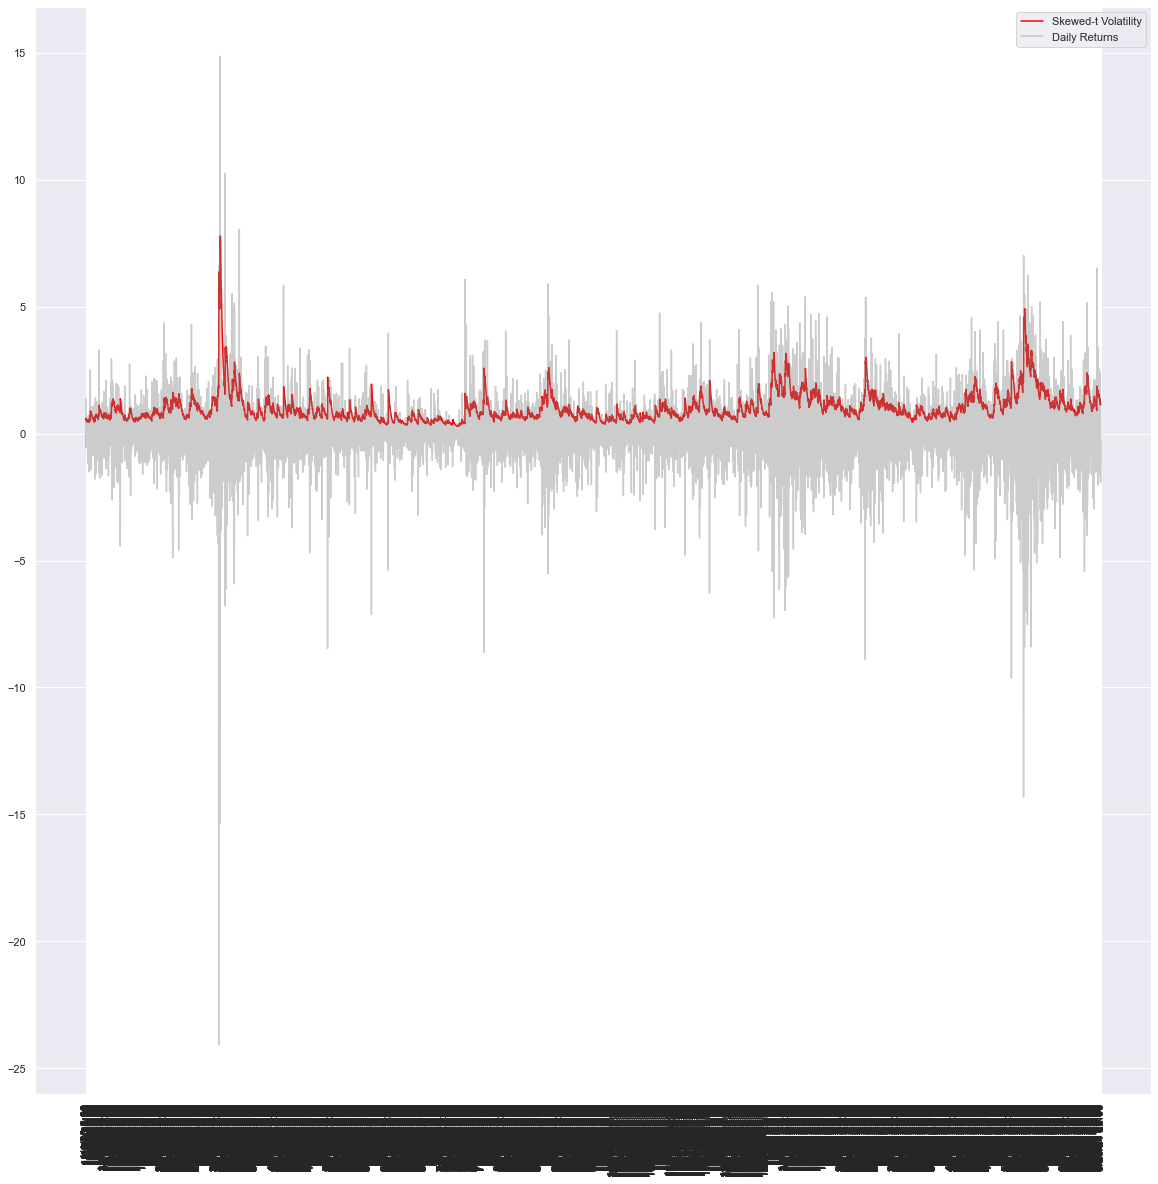

In [70]:
# Plot model fitting results
plt.figure(figsize=(40,20))
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(eth_data['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.xticks(rotation = 90)
plt.legend(loc = 'upper right')
plt.show()

# continue with forecasting

In [25]:
#continue with forecasting
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

          parameter        p-value
mu         0.031719   2.215032e-05
omega      0.014608   3.845644e-02
alpha[1]   0.075590   2.901768e-03
beta[1]    0.915763  1.470207e-242


In [26]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print parameter stats
print(para_summary)

          parameter   std-err    t-value
mu         0.031719  0.007477   4.242034
omega      0.014608  0.007057   2.069956
alpha[1]   0.075590  0.025383   2.977957
beta[1]    0.915763  0.027534  33.259860


In [27]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)

# Store p-values in DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = df.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
df.columns = col_names
df

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,0.91245,0.813616,0.80771,0.594164,0.5856,0.543807,0.655089,0.579149,0.509898,0.487339


In [28]:
# Display the significant lags
mask = df < 0.05
df[mask].dropna(axis=1)

""
P-values


In [29]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : -17711.18564765842
Log-likelihood of skewt GARCH : -16387.776530300238


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [116]:
# def evaluate(observation, forecast): 
#     # Call sklearn function to calculate MAE
#     mae = mean_absolute_error(observation, forecast)
#     print(f'Mean Absolute Error (MAE): {round(mae,3)}')
#     # Call sklearn function to calculate MSE
#     mse = mean_squared_error(observation, forecast)
#     print(f'Mean Squared Error (MSE): {round(mse,3)}')
#     return mae, mse

# # Backtest model with MAE, MSE
# evaluate(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), egarch_vol**2)

NameError: name 'egarch_vol' is not defined

In [ ]:
# # Plot the actual Bitcoin volatility
# plt.plot(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), 
#          color = 'grey', alpha = 0.4, label = 'Daily Volatility')

# # Plot EGARCH  estimated volatility
# plt.plot(egarch_vol**2, color = 'red', label = 'EGARCH Volatility')

# plt.legend(loc = 'upper right')
# plt.show()

# Simulation and bootstrap forecasting

In [48]:
# The paths for the final observation
sim_forecasts = egarch_result.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = egarch_result.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

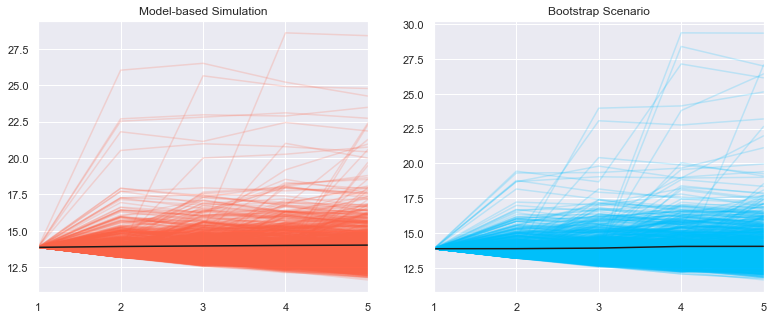

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

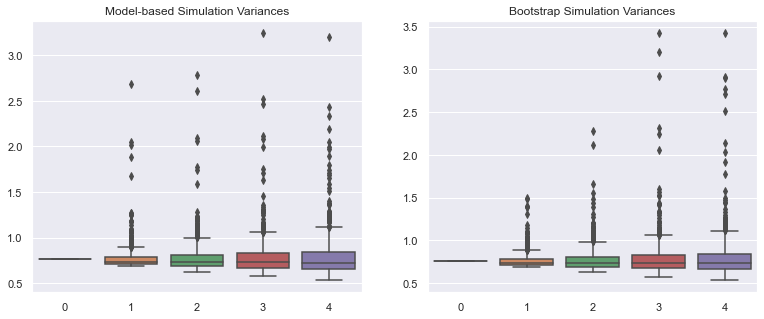

In [50]:
# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()

# VaR in financial risk management

In [79]:
d = np.array('2021-01-01 00:00:00', dtype=np.datetime64)

In [80]:
am = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
res = am.fit(disp='off', last_obs=d)

In [86]:
forecasts = res.forecast(start=d)
cond_mean = forecasts.mean[8786:]
cond_var = forecasts.variance[8786:]
q = am.distribution.ppf([0.01, 0.05], res.params[5])
print(q)

[-2.64041262 -1.39181931]


In [87]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,1.000000,1.00000
mean,2.297254,1.20627
std,NaN,NaN
min,2.297254,1.20627
25%,2.297254,1.20627
50%,2.297254,1.20627
75%,2.297254,1.20627
max,2.297254,1.20627


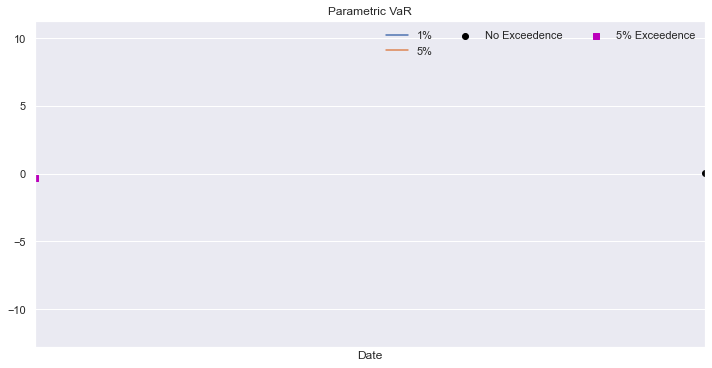

In [88]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2019 = bitcoin_data.Return[8786:]
rets_2019.name = 'BTCUSD Return'

c = []
for idx in value_at_risk.index:
    if rets_2019[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2019[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2019.index[sel],
        -rets_2019.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Parametric VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

In [89]:
# Obtain model estimated residuals and volatility
gm_resid = res.resid
gm_std = res.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Obtain the empirical quantiles
q = gm_std_resid.quantile([.01, .05])
print(q)

0.01   -2.738960
0.05   -1.365297
dtype: float64


In [90]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,1.000000,1.000000
mean,2.383362,1.183096
std,NaN,NaN
min,2.383362,1.183096
25%,2.383362,1.183096
50%,2.383362,1.183096
75%,2.383362,1.183096
max,2.383362,1.183096


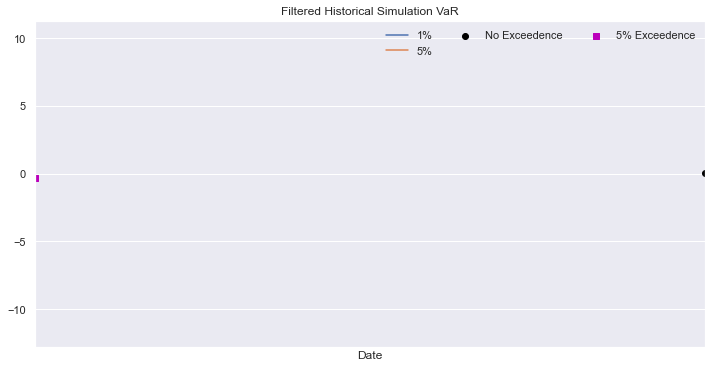

In [92]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2019 = bitcoin_data.Return[8786:]
rets_2019.name = 'BTCUSD Return'

c = []
for idx in value_at_risk.index:
    if rets_2019[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2019[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2019.index[sel],
        -rets_2019.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Filtered Historical Simulation VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

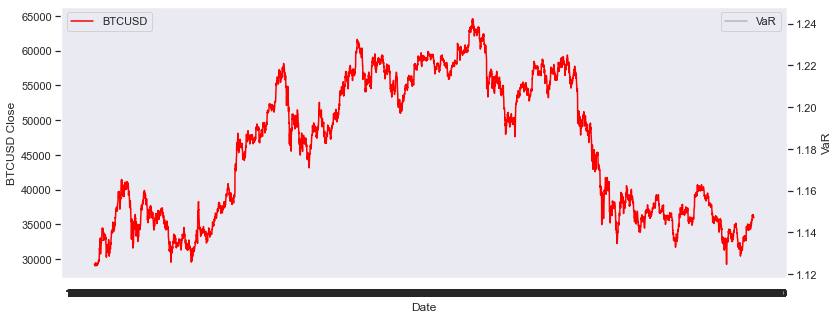

In [93]:
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

ax1.grid(False)
ax2.grid(False)

ax1.plot(bitcoin_data.loc[value_at_risk.index[0]:].index, bitcoin_data.loc[value_at_risk.index[0]:].close, 
         color='red', label='BTCUSD')
ax2.plot(value_at_risk['5%'].index, value_at_risk['5%'], color='grey', label='VaR', alpha=0.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('BTCUSD Close')
ax2.set_ylabel('VaR')

ax1.legend(loc='upper left')
ax2.legend()

plt.show()

# Add covariance?

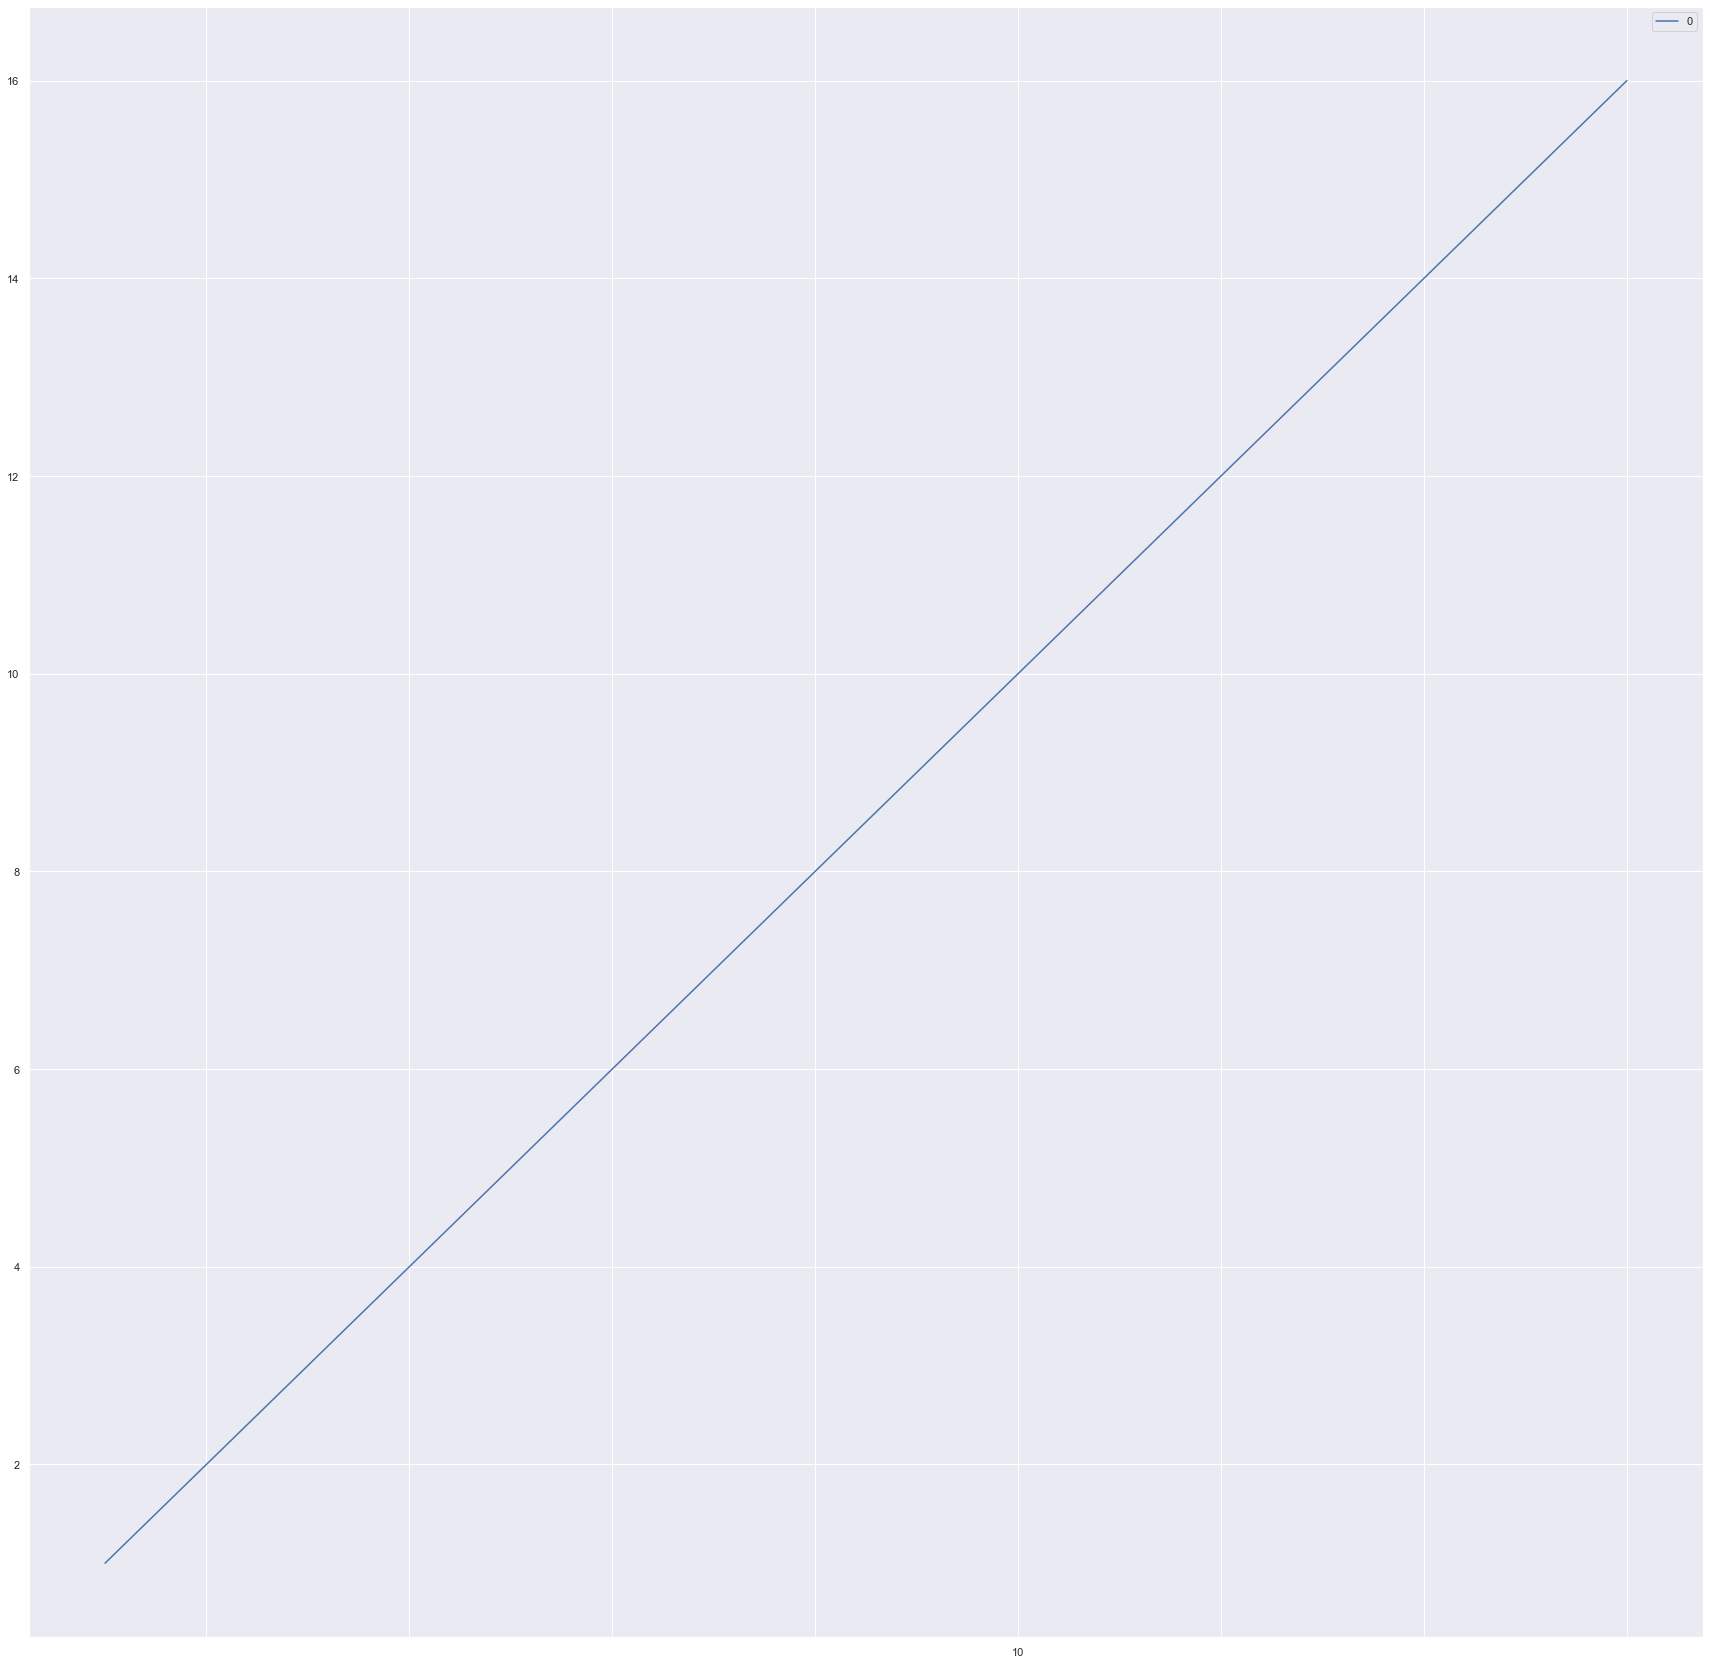

In [108]:
from matplotlib import pyplot as plt
x = pd.DataFrame([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
ax = x.plot.line()
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)